# COMP 579 - Assignment 2
# [Ling Fei Zhang](https://github.com/Ling01234), 260985358
# [Brandon Ma](https://github.com/brandon840), 260983550

In [28]:
import numpy as np
import gymnasium as gym

# Question 1

Here, we will set a few parameters for our environment.

In [29]:
ALPHAS = [0.01, 0.1, 0.5]
GAMMA = 0.95
TEMPERATURE = [0.05, 0.1, 50]
EPISODES = 5500
SEEDS = np.arange(10)
EPSILON = 0.2

## SARSA

Sarsa implementation:

In [30]:
import matplotlib.pyplot as plt
from scipy.special import softmax
import random
from tqdm import tqdm
from scipy.stats import sem
import time
# from gymnasium.envs.toy_text.frozen_lake import generate_random_map

# Actions:
# 0: left
# 1: down
# 2: right
# 3: up

# params initialization
ALPHAS = [0.01, 0.1, 0.5]
GAMMA = 0.95
TEMPERATURE = [0.05, 0.1, 50]
EPISODES = 5500
SEEDS = np.arange(10)
EPSILON = 0.2


class SARSA:
    def __init__(self, env, alpha, temp, gamma, num_episodes, expected, epsilon, seed):
        self.env = env
        self.alpha = alpha
        self.temp = temp
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.expected = expected
        self.epsilon = epsilon
        self.state_num = env.observation_space.n
        self.action_num = env.action_space.n
        self.learned_policy = np.zeros(self.state_num)  # learned policy
        # action value matrix
        self.Qvalues = np.zeros((self.state_num, self.action_num))
        self.reward = []
        self.seed = seed

    def select_action(self, state, episode):
        """
        This function selects an action given a state in the game.
        The exploration is done using softmax (Boltmann).

        Args:
            state (int): current state in the game
            episode (int): current episode in the run
        """
        random.seed(self.seed)
        action_values = self.Qvalues[state, :]

        if episode % 11 == 0:
            # randomized best action
            action = np.random.choice(
                np.where(action_values == np.max(action_values))[0])
            return action

        preferences = action_values/self.temp
        preferences = softmax(preferences)
        action = np.random.choice(a=np.arange(
            self.action_num), p=preferences)
        return action

    def simulate_episodes(self, verbose=False):
        """
        This function simulates episodes in the frozen lake environment

        Args:
            verbose (bool, optional): set to True for some print statements. Defaults to False.

        Returns:
            np array: an array that contains the reward for each episode
        """
        random.seed(self.seed)
        for episode in range(1, self.num_episodes+1):
            # reset env
            (state, _) = self.env.reset()
            action = self.select_action(state, episode)

            if verbose:
                print(f"Simulating episode {episode}.")

            episode_reward = 0
            terminal = False

            # move at most 100 times in a single episode
            # avoid to be stuck in infinite loop
            # if game can't terminate in 100 moves -> reward 0
            for s in range(100):
                if terminal:
                    break

                (next_state, reward, terminal, _, _) = self.env.step(action)
                episode_reward += reward * (self.gamma ** s)

                # next action
                next_action = self.select_action(next_state, episode)

                if episode % 11 != 0:  # does not update Qvalues on testing episode
                    if not self.expected:  # sarsa
                        self.sarsa_update(
                            state, next_state, action, next_action, reward, terminal)

                    else:  # expected sarsa
                        self.expected_update(
                            state, next_state, action, reward, terminal)

                state = next_state
                action = next_action

            if episode % 10 == 0:  # update policy for each segment
                self.final_policy()
            self.reward.append(episode_reward)

        self.final_policy()

    def sarsa_update(self, state, next_state, action, next_action, reward, terminal):
        """
        Update rule for SARSA.

        Args:
            state (int): current state
            next_state (int): next state
            action (int): current action
            next_action (int): next action
            reward (int): reward
            terminal (bool): True if agent is at terminal state, False otherwise
        """
        if not terminal:
            loss = reward + self.gamma * \
                self.Qvalues[next_state, next_action] - \
                self.Qvalues[state, action]
            self.Qvalues[state, action] += self.alpha * loss
        else:  # terminal state
            loss = reward - self.Qvalues[state, action]
            self.Qvalues[state, action] += self.alpha * loss

    def expected_update(self, state, next_state, action, reward, terminal):
        """
        Update rule for Expected SARSA.

        Args:
            state (int): current state
            next_state (int): next state
            action (int): current action
            reward (int): reward
        """
        expected = 0

        if not terminal:
            action_values = self.Qvalues[next_state, :]
            preferences = action_values/self.temp
            preferences = softmax(preferences)

            for a in range(self.action_num):
                expected += preferences[a] * self.Qvalues[next_state][a]

        loss = reward + self.gamma * expected - \
            self.Qvalues[state, action]
        self.Qvalues[state, action] += self.alpha * loss

    def final_policy(self):
        """
        Calculate the best policy based on the episodes played.
        """
        random.seed(self.seed)
        for i in range(self.state_num):
            self.learned_policy[i] = np.random.choice(np.where(
                self.Qvalues[i] == np.max(self.Qvalues[i]))[0])  # may have more than 1 max

    def visualize(self, num_games, slippery=True):
        """
        Visualize the game being played on pygame

        Args:
            num_games (int): number of games to be played
            slippery (bool): True if env is slippery, False otherwise
        """
        for _ in range(num_games):
            env = gym.make("FrozenLake-v1", desc=None,
                           map_name="4x4", is_slippery=slippery, render_mode="human")
            (state, prob) = env.reset()
            env.render()
            time.sleep(1)

            terminal = False
            for i in range(100):  # 100 steps game max
                if not terminal:
                    (state, reward, terminal, _, _) = env.step(
                        int(self.learned_policy[state]))
                    time.sleep(0.5)
                else:  # terminal state
                    break
            time.sleep(1)
            env.close()

    def train_reward(self):
        """
        Obtain the last 10 training episode rewards

        Returns:
            np array: reward of last 10 training episodes
        """
        return sum(self.reward[-11:-1])/10

    def test_reward(self):
        """
        Obtain the last testing episode reward

        Returns:
            int: last testing episode reward
        """
        return self.reward[-1]


def training_sarsa():
    """
    Function to simulate sarsa in training.
    The function plots the alpha values against return by agent.
    The function illustrates the effect of 3 different temperatures.
    """
    for temp in tqdm(TEMPERATURE):
        rewards_train = []
        for alpha in ALPHAS:
            average_reward_train = 0
            for seed in SEEDS:
                env = gym.make("FrozenLake-v1", desc=None,
                               map_name="4x4", is_slippery=True)
                env.reset()
                sarsa = SARSA(env, alpha, temp, GAMMA,
                              EPISODES, False, EPSILON, seed)
                sarsa.simulate_episodes()
                # final_policy = sarsa.learned_policy
                train_reward = sarsa.train_reward()
                average_reward_train += train_reward

            average_reward_train /= 10
            rewards_train.append(average_reward_train)

        plt.plot(ALPHAS, rewards_train, label=f"temperature = {temp}")

    plt.legend(bbox_to_anchor=(1, 0.5), loc="best")
    plt.title("Training on SARSA")
    plt.xlabel("alpha")
    plt.ylabel("Return")
    plt.show()


def testing_sarsa():
    """
    Function to simulate sarsa in testing.
    The function plots the alpha values against return by agent.
    The function illustrates the effect of 3 different temperatures.
    """
    for temp in tqdm(TEMPERATURE):
        rewards_test = []
        for alpha in ALPHAS:
            average_reward_test = 0
            for seed in SEEDS:
                env = gym.make("FrozenLake-v1", desc=None,
                               map_name="4x4", is_slippery=True)
                env.reset()
                sarsa = SARSA(env, alpha, temp, GAMMA,
                              EPISODES, False, EPSILON, seed)
                sarsa.simulate_episodes()
                # final_policy = sarsa.learned_policy
                test_reward = sarsa.test_reward()
                average_reward_test += test_reward

            average_reward_test = average_reward_test/10
            rewards_test.append(average_reward_test)

        plt.plot(ALPHAS, rewards_test, label=f"temperature = {temp}")

    plt.legend(bbox_to_anchor=(1, 0.5), loc="best")
    plt.title("Testing on SARSA")
    plt.xlabel("alpha")
    plt.ylabel("Return")
    plt.show()


def best_params_sarsa(alpha, temp):
    """
    Plot the learning curve based on the best params on sarsa.

    Args:
        alpha (float): alpha value
        temp (float): temperature value
    """
    train_reward = []
    for seed in tqdm(SEEDS):
        env = gym.make("FrozenLake-v1", desc=None,
                       map_name="4x4", is_slippery=True)
        env.reset()
        sarsa = SARSA(env, alpha, temp, GAMMA, EPISODES,
                      False, EPSILON, seed)  # best params chosen
        sarsa.simulate_episodes()
        reward = sarsa.reward
        train_reward.append(reward)

    train_reward = np.array(train_reward)
    train_reward_mean = np.mean(train_reward, axis=0)
    sd = np.std(train_reward_mean)
    x = np.arange(5500)

    plt.plot(x, train_reward_mean)
    plt.fill_between(x, 0, train_reward_mean + sd, alpha=0.35, color="g")
    plt.title("Return of Agent over the Course of Training for SARSA")
    plt.xlabel("Episode averaged over 10 runs")
    plt.ylabel("Return")
    plt.xlim(0, 6000)
    plt.show()


def training_esarsa():
    """
    Function to simulate expected sarsa in training.
    The function plots the alpha values against return by agent.
    The function illustrates the effect of 3 different temperatures.
    """
    for temp in tqdm(TEMPERATURE):
        rewards_train = []
        for alpha in ALPHAS:
            average_reward_train = 0
            for seed in SEEDS:
                env = gym.make("FrozenLake-v1", desc=None,
                               map_name="4x4", is_slippery=True)
                env.reset()
                sarsa = SARSA(env, alpha, temp, GAMMA,
                              EPISODES, True, EPSILON, seed)
                sarsa.simulate_episodes()
                # final_policy = sarsa.learned_policy
                train_reward = sarsa.train_reward()
                average_reward_train += train_reward

            average_reward_train = average_reward_train/10
            rewards_train.append(average_reward_train)

        plt.plot(ALPHAS, rewards_train, label=f"temperature = {temp}")

    plt.legend(bbox_to_anchor=(1, 0.5), loc="best")
    plt.title("Training on Expected SARSA")
    plt.xlabel("alpha")
    plt.ylabel("Return")
    plt.show()


def testing_esarsa():
    """
    Function to simulate expected sarsa in testing.
    The function plots the alpha values against return by agent.
    The function illustrates the effect of 3 different temperatures.
    """
    for temp in tqdm(TEMPERATURE):
        rewards_test = []
        for alpha in ALPHAS:
            average_reward_test = 0
            for seed in SEEDS:
                env = gym.make("FrozenLake-v1", desc=None,
                               map_name="4x4", is_slippery=True)
                env.reset()
                sarsa = SARSA(env, alpha, temp, GAMMA,
                              EPISODES, True, EPSILON, seed)
                sarsa.simulate_episodes()
                # final_policy = sarsa.learned_policy
                test_reward = sarsa.test_reward()
                average_reward_test += test_reward

            average_reward_test = average_reward_test/10
            rewards_test.append(average_reward_test)

        plt.plot(ALPHAS, rewards_test, label=f"temperature = {temp}")

    plt.legend(bbox_to_anchor=(1, 0.5), loc="best")
    plt.title("Testing on Expected SARSA")
    plt.xlabel("alpha")
    plt.ylabel("Return")
    plt.show()


def best_params_esarsa(alpha, temp):
    """
    Plot the learning curve based on the best params on expected sarsa.

    Args:
        alpha (float): alpha value
        temp (float): temperature value
    """
    train_reward = []
    for seed in tqdm(SEEDS):
        env = gym.make("FrozenLake-v1", desc=None,
                       map_name="4x4", is_slippery=True)
        env.reset()
        sarsa = SARSA(env, alpha, temp, GAMMA, EPISODES,
                      True, EPSILON, seed)  # best params chosen
        sarsa.simulate_episodes()
        reward = sarsa.reward
        train_reward.append(reward)

    train_reward = np.array(train_reward)
    train_reward_mean = np.mean(train_reward, axis=0)
    sd = np.std(train_reward_mean)
    x = np.arange(5500)

    plt.plot(x, train_reward_mean)
    plt.fill_between(x, 0, train_reward_mean + sd, alpha=0.35, color="g")
    plt.title("Return of Agent over the Course of Training for Expected SARSA")
    plt.xlabel("Episode averaged over 10 runs")
    plt.ylabel("Return")
    plt.xlim(0, 6000)
    plt.show()


Test out a run for SARSA.

In [31]:
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=True)
env.reset()
sarsa = SARSA(env, 0.1, 0.5, GAMMA, EPISODES, False, EPSILON, 1)
sarsa.simulate_episodes()
final_policy = sarsa.learned_policy
print("final policy:\n", final_policy.reshape(4,4)) #tabular format to better visualize
train_reward = sarsa.train_reward()
print(f"train reward: {train_reward}")
test_reward = sarsa.test_reward()
print(f"test reward: {test_reward}")

#uncomment this line if you want to vizualize the game
# sarsa.visualize(10)

final policy:
 [[1. 3. 1. 3.]
 [2. 3. 0. 2.]
 [2. 2. 1. 1.]
 [1. 1. 1. 0.]]
train reward: 0.0
test reward: 0.0


### Effect of parameters on final training performance for SARSA

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:75: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:50: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:167: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
100%|██████████| 3/3 [06:37<00:00, 132.37s/it]


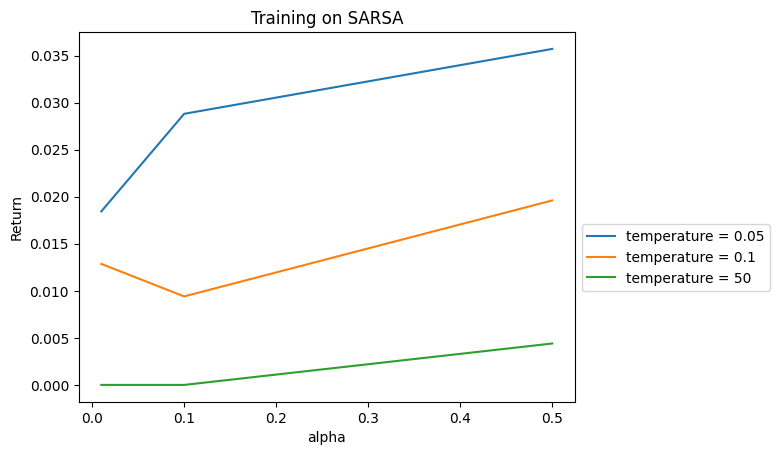

In [32]:
training_sarsa()

### Effect of parameters on final testing performance for SARSA

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:75: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:50: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:167: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
100%|██████████| 3/3 [06:46<00:00, 135.36s/it]


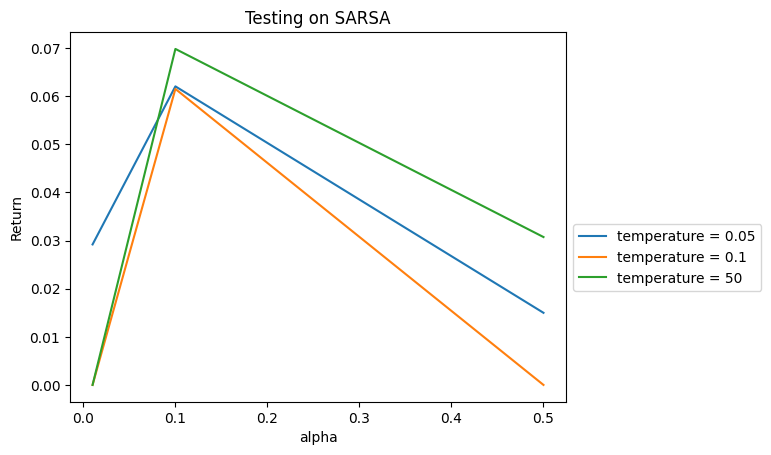

In [33]:
testing_sarsa()

### Best parameter for SARSA
We will pick the best hyperparameter based on the testing set. Then, the best paramaters for SARSA is when $\alpha = 0.1$ and temperature = 50. We can then use these parameters to plot a graph below

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:75: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:50: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:167: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


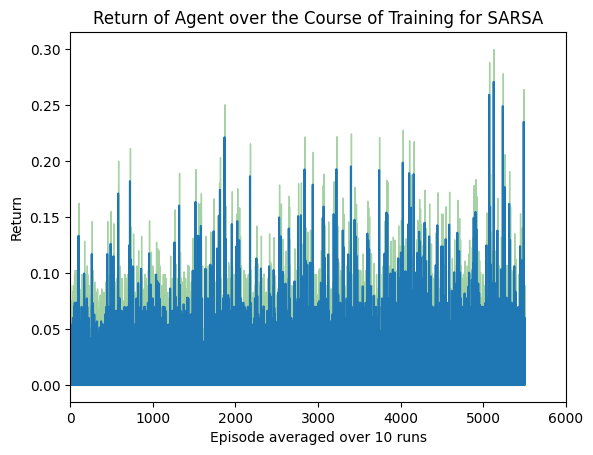

In [34]:
best_params_sarsa(0.1, 50)

### Conclusion for SARSA

First, we notice that the return by the agent is quite small. This can be due from a few different reasons. One of the main one is the fact that the environment is slippery. This means that the player will only move to its intended direction with probability $\frac{1}{3}$, and in either perpendicular directions with equal probability of $\frac{1}{3}$. This is a huge draw back for the agent, as it can not just follow the path that one would in a non-slippery environment. For example, if the environment is non-slippery and the agent is at the start state, then the optimal starting path for the agent would be to go down twice (state 1 to 5 to 9). However, given a slippery environment, the agent cannot choose to go down from state 5 to state 9. This is because it has just a good a chance to go into the hole on the right, as it does to go down. Thus, it must learn to go left, in the hope to eventually slip downwards. However, this makes the number of steps per episode a lot larger, and thus decreases the return by the agent. 

Second, we can also analyze the effect of $\alpha$ on the graphs. $\alpha$ weights the importance of the TD error in the updating step. In other words, the importance in difference between the predicted value at a state-action pair and the boostrapped estimate. From our results, we observe that an $\alpha$ value of 0.1 is best during both training and testing.

Finally, we can see that a temperature of 50 is optimal for Sarsa testing. As we use softmax exploration during learning, temperature is a hyperparameter that balances the probability distribution for a greedy pick and an equal pick between the state-action values. Since the softmax exploration is given as follows
\begin{equation*}
    \frac{\exp{(Q_t(s,a)/\tau)}}{\sum_{i \in A} \exp{(Q_t(s,i)/\tau)}}
\end{equation*}
we can see that as $\tau \rightarrow 0$, softmax exploration becomes like a greedy action selection. On the other hand, as $\tau \rightarrow \infty$, softmax results in picking an action at random (i.e. with equal probability). 

## Expected SARSA

Expected sarsa takes the weighted sum of all possible next actions. In other words, the next state action values are weighted in respect to the probability of taking that action. In our agent, we will implement the policy of choosing an action given the next state by using the softmax exploration. Formally, we have
\begin{equation*}
\pi(a|s_{t+1}) = \frac{e^{Q(s_{t+1},a)/\tau}}{\sum_{a \in A}e^{Q(s_{t+1},a)/\tau}}
\end{equation*}
where $A$ is the set of all actions.

### Effect of parameters on final training performance for Expected SARSA

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:75: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:50: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:167: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
100%|██████████| 3/3 [06:10<00:00, 123.61s/it]


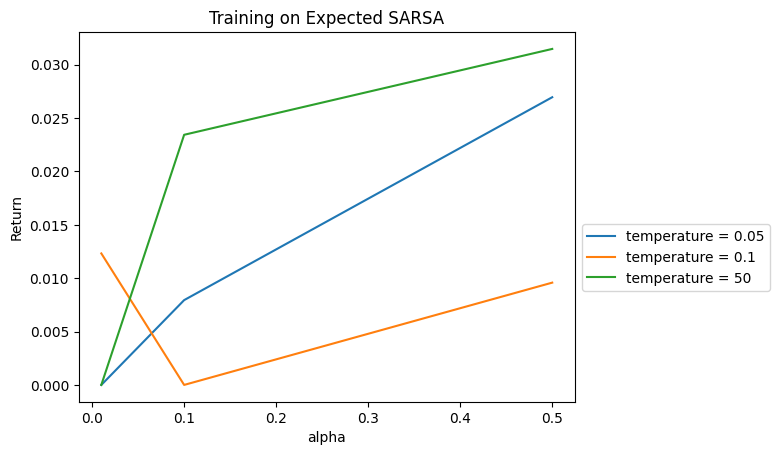

In [26]:
training_esarsa()

### Effect of parameters on final testing performance for Expected SARSA

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:75: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:50: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:167: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
100%|██████████| 3/3 [06:44<00:00, 134.94s/it]


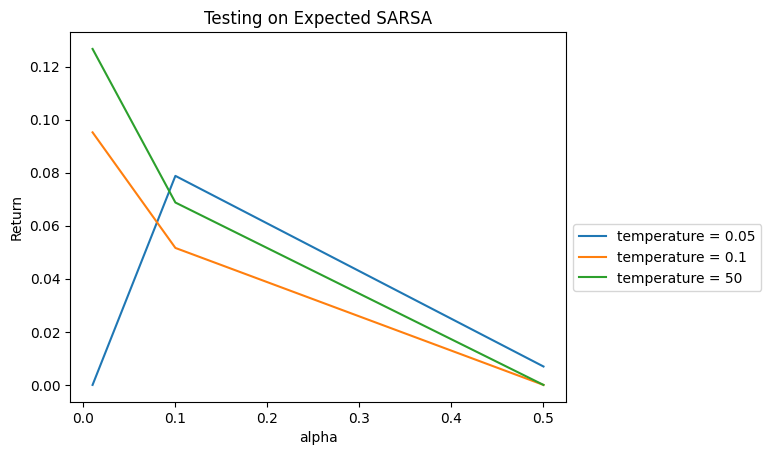

In [27]:
testing_esarsa()

### Best parameter for Expected SARSA

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:75: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:50: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
C:\Users\Ling0\AppData\Local\Temp\ipykernel_11404\2544052379.py:167: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)
100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


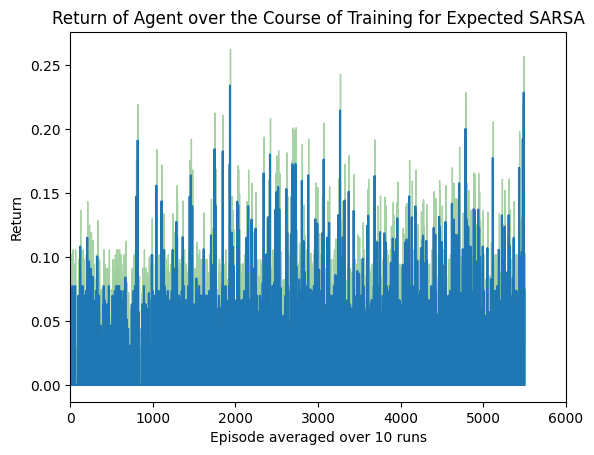

In [36]:
best_params_esarsa(0.01, 50)

### Conclusion for Expected SARSA

We observe that the results of Expected Sarsa is greater than Sarsa. We see a maximal return of slightly above 0.12 with $\alpha = 0.01$ and temperature = 50 during testing using Expected Sarsa, while Sarsa is slightly above 0.07 with $\alpha = 0.1$ and temperature = 50. This is to be expected, as Expected Sarsa is shown to perform better than Sarsa. 

However, it's still worth mentioning that the return is small. This is because we know that the optimal path to the goal state can be achieved in 6 steps. In other words, we know that the optimal return that an agent can achieve is
$$
(0.95)^6 * 1 \approx 0.7350918906249998
$$
This again is a direct consequence of the slippery environment, where the intended direction by the agent is only achieved $\frac{1}{3}$ of the time. In fact, this completely changes the agent's strategy, and forces the agent to make safe and passive moves, which in turn increases the number of steps needed to reach the end goal. 

In Expected Sarsa, we observe the optimal $\alpha$ value to be 0.5 during training, and 0.01 during testing. On the same note, we observe the optimal temperature to be 50 during both training and testing.

The effect of $\alpha$ and the temperature is the same as described in the conclusion for Sarsa, since the two algorithms are almost the same, with the exception of the update rule. 

## Sarsa vs Expected Sarsa Theoretical Trade Off

It's worth noting that Sarsa and Expected Sarsa are implemented very similarly, with the exception of the update rule. Sarsa is an on-policy algorithm, while Expected Sarsa can be either on-policy or off-policy. 

Overall, both Sarsa and Expected Sarsa have their own benefits. For instance, Expected Sarsa is able to achieve better returns since calculating the expected value over all future state-action pairs reduces variance from the random selection of the next action $A_{t+1}$. However, this is also more computationally expensive than Sarsa, since Sarsa only sample subsequent state action pairs stochastically. 

# Question 2

Parameter initialization

In [7]:
# params initialization:
ALPHAS = [1/4, 1/8, 1/16]
EPSILONS = [0.05, 0.15, 0.25]
BINS = 10
GAMMA = 0.99
EPISODES = 1000
RUNS = 10

## Q-learning

Q-Learning implementation:

In [8]:
import random
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.colors as mcolors
from scipy.stats import sem

# Actions:
# 0: left
# 1: right

# params initialization:
ALPHAS = [1/4, 1/8, 1/16]
GAMMA = 0.95
EPSILONS = [0.05, 0.15, 0.25]
BINS = 10
EPISODES = 1000
RUNS = 10


class Qlearning:
    def __init__(self, env, alpha, gamma, epsilon, num_episodes, num_bins, seed) -> None:
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_episodes = num_episodes
        self.num_bins = num_bins
        self.lowerbound = env.observation_space.low
        self.lowerbound[1] = -3.5
        self.lowerbound[3] = -10
        self.upperbound = env.observation_space.high
        self.upperbound[1] = 3.5
        self.upperbound[3] = 10
        #self.env.seed(seed)
        self.seed = seed
        random.seed(self.seed)
        self.num_action = env.action_space.n
        self.reward = []
        self.Qvalues = np.random.uniform(low=-0.001, high=0.001,
                                         size=(num_bins, num_bins, num_bins, num_bins, self.num_action))
        self.bins = []
        for i in range(4):
            self.bins.append(np.linspace(
                self.lowerbound[i], self.upperbound[i], self.num_bins))

    def discritize_state(self, state):
        """
        Discritize continuous state into a discrete state

        Args:
            state (list of length 4): Current continuous state of agent

        Returns:
            state (4-tuple): Current discritized state of agent
        """
        new_state = []
        for i in range(4):
            index = np.maximum(np.digitize(state[i], self.bins[i]) - 1, 0)
            new_state.append(index)

        return tuple(new_state)

    def select_action(self, state, episode):
        """
        Select action given a state

        Args:
            state (4-tuple): Current state of the agent, continuous
            episode (int): Current episode of the run

        Returns:
            int: Action chosen by the agent
        """
        random.seed(self.seed)

        # lower exploration rate as we run many episodes
        if episode > 700:
            self.epsilon *= 0.99

        # epsilon greedy
        number = np.random.random()
        if number < self.epsilon:  # uniformly choose action
            return np.random.choice(self.num_action)

        # greedy selection
        state = self.discritize_state(state)
        best_actions = np.where(
            self.Qvalues[state] == np.max(self.Qvalues[state]))[0]
        return np.random.choice(best_actions)

    def simulate_episodes(self):
        """
        Simulate a specified number of episodes
        """
        for episode in range(1, self.num_episodes+1):
            # reset env
            (state, _) = self.env.reset()
            state = list(state)

            # run episode
            episode_reward = 0
            terminal = False
            while not terminal:
                discritized_state = self.discritize_state(state)
                action = self.select_action(state, episode)
                (next_state, reward, terminal, _, _) = self.env.step(action)
                episode_reward += reward

                next_discritized_state = self.discritize_state(
                    list(next_state))

                q_max = np.max(self.Qvalues[next_discritized_state])
                self.qlearning_update(
                    terminal, reward, action, discritized_state, q_max)

                state = next_state

            self.reward.append(int(episode_reward))

    def qlearning_update(self, terminal, reward, action, state, q_max):
        """
        Qlearning update rule

        Args:
            terminal (bool): True if at terminal state, False otherwise
            reward (int): Reward of the agent at current state
            action (int): Action taken by agent
            state (4-tuple): Discrete state of the agent
            q_max (float): Max Q value of the next state
        """
        if not terminal:
            loss = reward + self.gamma * q_max - \
                self.Qvalues[state + (action,)]
        else:
            loss = reward - self.Qvalues[state + (action,)]

        self.Qvalues[state + (action,)] += self.alpha * loss

    def visualize(self, games):
        """
        Visualize the game played for a specified number of games.
        Prints out the reward for each game.

        Args:
            games (int): Number of games to be played
        """
        random.seed(self.seed)
        env = gym.make("CartPole-v1", render_mode="human")
        for game in range(games):
            (state, _) = env.reset()
            env.render()
            rewards = 0

            for _ in range(500):
                discritized_state = self.discritize_state(state)
                best_actions = np.where(self.Qvalues[discritized_state] == np.max(
                    self.Qvalues[discritized_state]))[0]
                action = np.random.choice(best_actions)
                (state, reward, terminal, _, _) = env.step(action)
                rewards += int(reward)
                time.sleep(0.05)

                if terminal:
                    time.sleep(1)
                    break
            print(f"reward for game {game}: {rewards}")
        env.close()


def train_qlearning():
    best_average_reward = []

    x = np.arange(1000)
    colors = [mcolors.TABLEAU_COLORS["tab:blue"],
              mcolors.TABLEAU_COLORS["tab:green"], mcolors.TABLEAU_COLORS["tab:orange"]]
    for epsilon in tqdm(EPSILONS):
        for index, alpha in enumerate(ALPHAS):
            average_reward = []
            for seed in range(RUNS):
                env = gym.make("CartPole-v1")
                env.reset()
                qlearning = Qlearning(
                    env, alpha, GAMMA, epsilon, EPISODES, BINS, seed)
                qlearning.simulate_episodes()
                rewards = qlearning.reward
                average_reward.append(rewards)

            average_reward = np.mean(average_reward, axis=0)
            max_reward = np.empty(1000)
            max_reward.fill(np.max(average_reward))
            err = sem(average_reward)
            plt.plot(x, average_reward,
                     label=f"alpha = {alpha}", color=colors[index])
            plt.plot(
                x, max_reward, color=colors[index], linestyle="dashed", label=f"y = {int(max_reward[0])}")
            plt.fill_between(
                x, average_reward - err, average_reward + err, color=colors[index], alpha=0.5)
            
            if alpha == 0.25 and epsilon == 0.25:
                best_average_reward = average_reward
        
        

        plt.legend(bbox_to_anchor=(1, 0.5), loc="best")
        plt.title(f"Training Q-learning with epsilon = {epsilon:.2f}")
        plt.ylabel("Return")
        plt.yscale("log")
        plt.xlabel("Episode")
        plt.show()

    return best_average_reward


Test out a run for Qlearning and observe the returns.

In [9]:
env = gym.make("CartPole-v1")
(state, _) = env.reset()
qlearning = Qlearning(env, 1/4, GAMMA, 0.15, 1000, 10, seed=1)
qlearning.simulate_episodes()
rewards = qlearning.reward
print(f" last 100 rewards: {rewards[-100:]}")

#uncomment to visualize the game being played
# qlearning.visualize(10)

 last 100 rewards: [108, 109, 89, 99, 96, 123, 93, 99, 106, 108, 101, 90, 84, 102, 85, 95, 93, 108, 102, 91, 109, 121, 83, 96, 82, 81, 103, 99, 111, 143, 94, 93, 101, 112, 103, 82, 99, 123, 93, 74, 103, 112, 114, 114, 118, 97, 85, 105, 89, 95, 93, 102, 91, 84, 111, 94, 90, 87, 106, 116, 89, 93, 109, 91, 119, 79, 87, 113, 73, 83, 91, 113, 106, 93, 86, 77, 92, 95, 85, 97, 85, 135, 98, 98, 122, 96, 113, 97, 118, 102, 68, 76, 69, 89, 109, 112, 81, 120, 118, 100]


Based on the last 100 rewards, we can clearly see that our agent is learning!

### Effect of $\epsilon$ and $\alpha$ for Q-learning agent. 

  0%|          | 0/3 [00:00<?, ?it/s]

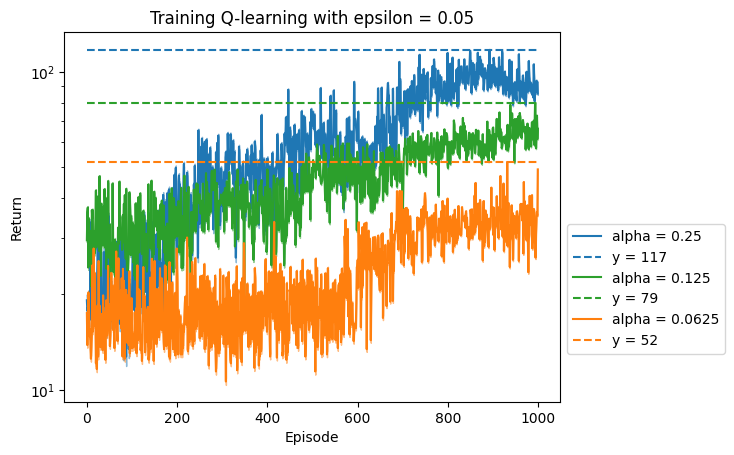

 33%|███▎      | 1/3 [07:11<14:23, 431.87s/it]

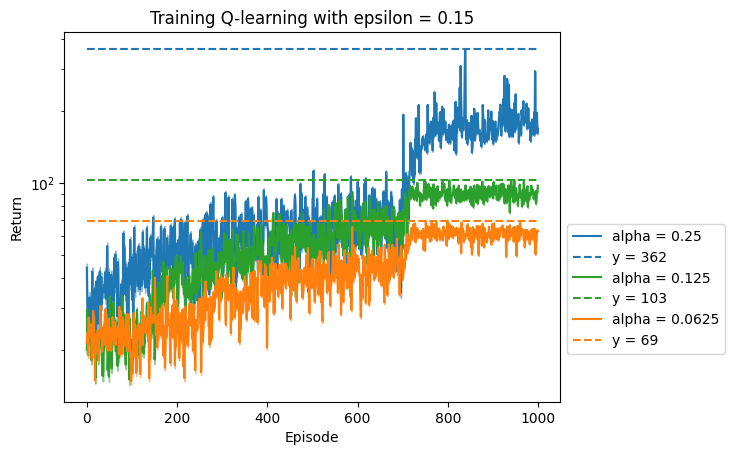

 67%|██████▋   | 2/3 [28:39<15:35, 935.24s/it]

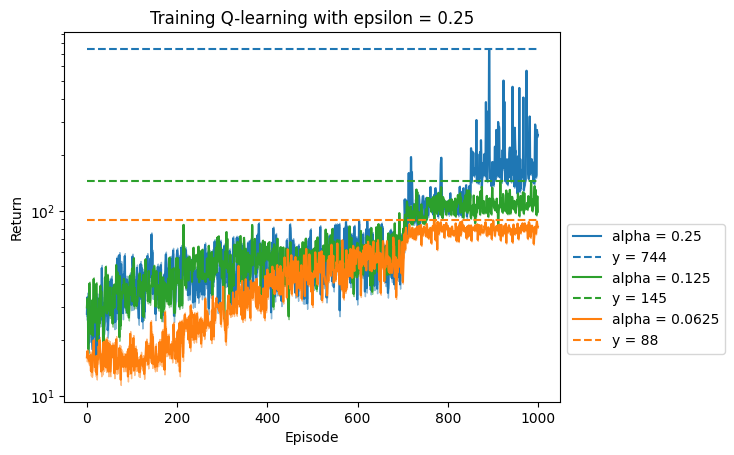

100%|██████████| 3/3 [1:25:03<00:00, 1701.11s/it]


In [10]:
best_run_Q = train_qlearning()

From the graphs above, we observe that the performance of the agent with $\alpha = \frac{1}{4}$ dominates the other $\alpha$ values. As for $\epsilon$ values, we can see that the optimal value is 0.25. We can also see that the highest return with these parameters is 744. 

## Actor Critic


Actor-Critic implementation:

In [16]:
from tqdm import trange
from scipy.special import softmax
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from scipy.stats import sem

# define environment and some params
env = gym.make("CartPole-v1")
num_actions = env.action_space.n
lowerbounds = env.observation_space.low
lowerbounds[1] = -3.5
lowerbounds[3] = -10
upperbounds = env.observation_space.high
upperbounds[1] = 3.5
upperbounds[3] = 10
env.close()

# param initialization
GAMMA = 0.99
ALPHAS = [1/4, 1/8, 1/16]
EPSILONS = [0.05, 0.15, 0.25]
EPISODES = 1000
MAX_STEPS = 10000
RUNS = 10
NUM_BINS = 10

# define bins for discritized states
# bins are separated evenly
bins = []
for i in range(4):
    bins.append(np.linspace(lowerbounds[i], upperbounds[i], NUM_BINS))


def feature(state):
    """
    Transforms a state into a one-hot encoded
    array. The returned array has length NUM_BINS * 4
    where each index represents a discritized state

    Args:
        state (4-tuple): Continous state of the agent

    Returns:
        np array: One-hot encoded array
    """
    state = list(state)
    one_hot = np.zeros(NUM_BINS * 4)
    for i in range(4):
        index = np.maximum(np.digitize(state[i], bins[i]) - 1, 0)
        one_hot[NUM_BINS * i + index] = 1  # one hot encoding

    return one_hot


class Actor():
    def __init__(self, env, alpha):
        """
        Initialize Actor class

        Args:
            env (env): Gym environment
            alpha (float): Learning Rate
        """
        self.env = env
        self.alpha = alpha
        self.weights = np.random.uniform(low=-0.001, high=0.001,
                                         size=(NUM_BINS * 4, num_actions))

    def policy(self, state):
        """
        Select action depending on the current Actor policy

        Args:
            state (4-tuple): Continuous state of the agent

        Returns:
            2-tuple: Returns the action and the action probabilities
        """
        approx = np.dot(feature(state), self.weights)
        probs = softmax(approx)
        action = np.random.choice(num_actions, p=probs)
        return action, probs


class Critic():
    def __init__(self, env, alpha) -> None:
        """
        Initialize Critic class

        Args:
            env (env): Gym environment
            alpha (float): Learning Rate
        """
        self.env = env
        self.alpha = alpha
        self.weights = np.random.uniform(low=-0.001, high=0.001,
                                         size=(NUM_BINS * 4))

    def state_value(self, state):
        """
        Returns the state value from the Critic

        Args:
            state (4-tuple): Continuous state of the agent

        Returns:
            float: state value from the critic
        """
        value = np.dot(feature(state), self.weights)
        return value


def train(actor, critic):
    """
    Trains the agent

    Args:
        actor (Actor): Select action depending on actor policy
        critic (Critic): Update value function based on critic

    Returns:
        3-tuple: Returns the total reward for each episode trained,
        the actor and the critic
    """
    env = gym.make("CartPole-v1")
    total_rewards = []
    for episode in range(1, EPISODES+1):
        episode_reward = 0
        state, _ = env.reset()
        terminal = False
        while not terminal:
            # choose action with actor policy
            action, probs = actor.policy(state)

            # step in the env
            next_state, reward, terminal, _, _ = env.step(action)
            episode_reward += reward

            # critic update
            loss = reward + GAMMA * \
                critic.state_value(next_state) - critic.state_value(state)
            critic.weights += critic.alpha * loss * feature(state)

            # policy update
            one_hot_action = np.zeros(num_actions)
            one_hot_action[action] = 1
            gradient_log = feature(
                state).reshape(-1, 1) - np.dot(feature(state).reshape(-1, 1), probs.reshape(1, -1))
            actor.weights += actor.alpha * loss * \
                gradient_log * one_hot_action.reshape(1, -1)

            state = next_state

        total_rewards.append(episode_reward)
    env.close()
    return total_rewards, actor, critic


def visualize(actor):
    """
    Visualize the game played with trained agent

    Args:
        actor (Actor): Trained actor policy
    """
    env = gym.make("CartPole-v1", render_mode="human")
    state, _ = env.reset()
    terminal = False
    r = 0
    while not terminal:
        action, _ = actor.policy(state)
        state, reward, terminal, _, _ = env.step(action)
        r += reward
        env.render()

    env.close()
    print(f"Test reward: {r}")


def train_ac():
    """
    Plot the effect of alpha (lr) on the AC algorithm

    Returns:
        2-tuple: Returns the best alpha and the respective, learned, actor
    """
    best_alpha = 0
    best_actor = None
    best_average_reward = None
    env = gym.make("CartPole-v1")
    x = np.arange(1000)
    colors = [mcolors.TABLEAU_COLORS["tab:blue"],
              mcolors.TABLEAU_COLORS["tab:green"], mcolors.TABLEAU_COLORS["tab:orange"]]

    for index, alpha in enumerate(ALPHAS):
        average_reward = []
        for seed in trange(RUNS):
            env.reset()
            #env.seed(seed)
            actor = Actor(env, alpha)
            critic = Critic(env, alpha)
            rewards, actor, critic = train(
                actor, critic)  # train on 1000 episodes
            average_reward.append(rewards)

        average_reward = np.mean(average_reward, axis=0)

        # obtain max reward value
        max_reward = np.empty(1000)
        max_reward.fill(np.max(average_reward))
        err = sem(average_reward)

        # plot
        plt.plot(x, average_reward,
                 label=f"alpha = {alpha}", color=colors[index])
        plt.plot(x, max_reward, color=colors[index],
                 linestyle="dashed", label=f"y = {int(max_reward[0])}")
        plt.fill_between(x, average_reward - err,
                         average_reward + err, color=colors[index], alpha=0.5)

        # update best hyperparameter
        if best_alpha < max_reward[0]:
            best_alpha = alpha
            best_actor = actor

        if alpha == 0.0625:
            best_average_reward = average_reward

    plt.legend(bbox_to_anchor=(1, 0.5), loc="best")
    plt.title(f"Training Actor Critic")
    plt.yscale("log")
    plt.ylabel("Return")
    plt.xlabel("Episode")
    plt.show()

    return best_alpha, best_actor, best_average_reward


Plotting the Return of Actor Critic with different $\alpha$ values.

100%|██████████| 10/10 [04:32<00:00, 27.29s/it]


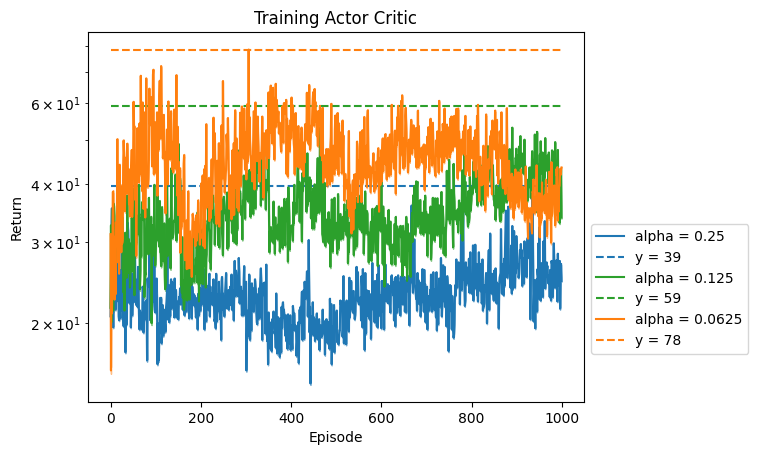

In [17]:
best_alpha, actor, best_run_AC = train_ac()

#uncomment this to vizualise the game being played with learned agent
# visualize(actor)

From the graph above, we can see that the best parameter is setting $\alpha = 1/16$. For our implementation, we set the learning rates for the actor and the critic to be the same value.

## Comparison of Q-Learning and Actor-Critic with best parameters

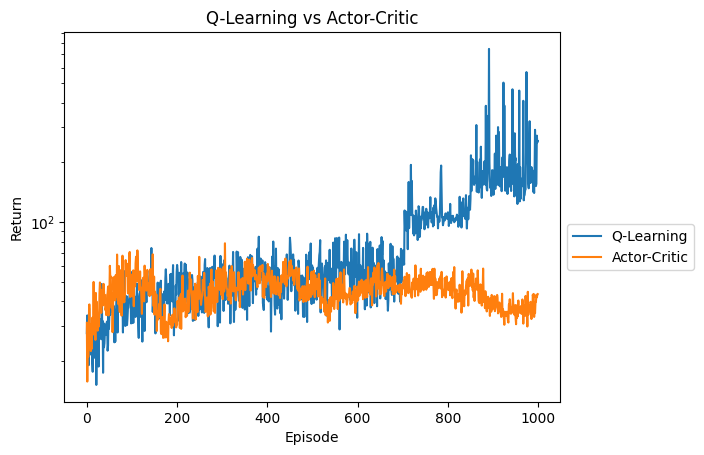

In [18]:
# Q-Learning
x = np.arange(1000)
plt.plot(x, best_run_Q, label="Q-Learning")

# Actor-Critic
plt.plot(x, best_run_AC, label="Actor-Critic")

plt.legend(bbox_to_anchor=(1, 0.5), loc="best")
plt.title("Q-Learning vs Actor-Critic")
plt.ylabel("Return")
plt.yscale("log")
plt.xlabel("Episode")
plt.show()


## Conclusions

The best parameters for Q-Learning were $\alpha = \frac{1}{4}$ and $\epsilon = \frac{1}{4}$ while the best learning rate for Actor-Critic was $\alpha = \frac{1}{16}$.

We can see from the above graph that Actor-Critic has trouble keeping up with Q-Learning. Q-Learning is able to achieve rewards well above 100 after 1000 episodes while Actor-Critic is still below 100. A reason for this could be that the linear value function approximator for the Actor-Critic algorithm is underfitting the problem. However, during training, Q-learning was a lot slower than Actor-Critic. It took around 5-10 minutes to train one model of Q-Learning while Actor-Critic only needed less than one minute of training time.

In sum, Q-learning seems to do a better job achieving high scores for the cartpole environment when compared to the actor critic method, but learns very slowly.